# Practical Session 9 - Atlas based segmentation

In [1]:
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [2]:
import torch
tensor_type = torch.DoubleTensor 

import os 
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Import data

In this practical session, images will be a set of digits, with a template to estimate.
Atlas estimation will be done using 19 images of the dataset, and the last digit will be considered as a new observation.

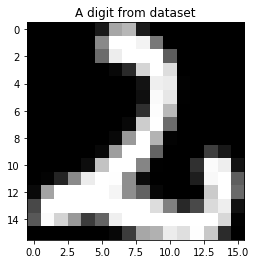

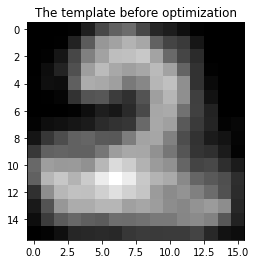

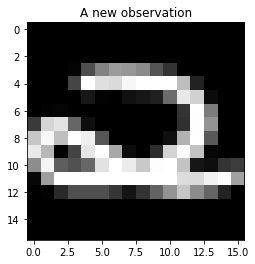

In [3]:
dico_images = {}
for i in range(1,20):
    dico_images[i] = np.array(mpimg.imread("./Images/digits/digit_2_sample_{}.png".format(i))) 
    
new_digit = np.array(mpimg.imread("./Images/digits/digit_2_sample_20.png")) 
digit_template =  np.array(mpimg.imread("./Images/digits/digit_2_mean.png")) 

plt.imshow(dico_images[1],cmap='gray')
plt.title('A digit from dataset')
plt.show()

plt.imshow(digit_template,cmap='gray')
plt.title('The template before optimization')
plt.show()

plt.imshow(new_digit,cmap='gray')
plt.title('A new observation')
plt.show()

# Registration

## Functions to do registration

In [4]:
def _swap_colums(ar, i, j):
    aux = np.copy(ar[:, i])
    ar[:, i] = np.copy(ar[:, j])
    ar[:, j] = np.copy(aux)
    return np.copy(ar)



def interpolate_image_torch(intensities, deformed_pixels, padding_width=1):
    '''
    This function, given original image in intensities tensor, 
    deformed pixels : coordinates of registered pixels in original image 
    returns the final registered image in deformed_intensities
    ------- 
    intensities : (nr,nc)
    deformed_pixels : (nr*nc,d)
    -------
    returns registered image in deformed_intensities, of shape (nr,nc)
    
    '''
    padding_color = 1.
    if intensities.ndim == 2:
        i,j = intensities.size()
        k = 1
        intensities_cp = intensities[...,np.newaxis]
    else :
        i,j,k = intensities.size()
        intensities_cp = intensities
        
    deformed_pixels += torch.from_numpy(np.array([float(padding_width), float(padding_width)])).view(1, 2).expand(i*j, 2).type(torch.DoubleTensor)

    padded_intensities = torch.ones((i + 2 * padding_width, j + 2 * padding_width, k)).type(torch.DoubleTensor) * padding_color
    padded_intensities[padding_width:padding_width + i, padding_width:padding_width + j] = intensities_cp

    u, v = deformed_pixels[:, 0], deformed_pixels[:, 1]

    u1 = torch.floor(u)
    v1 = torch.floor(v)

    u1 = torch.clamp(u1, 0, i - 1 + 2 * padding_width)
    v1 = torch.clamp(v1, 0, j - 1 + 2 * padding_width)
    u2 = torch.clamp(u1 + 1, 0, i - 1 + 2 * padding_width)
    v2 = torch.clamp(v1 + 1, 0, j - 1 + 2 * padding_width)

    fu = (u - u1).view(i * j, 1).expand(i*j, k)
    fv = (v - v1).view(i * j, 1).expand(i*j, k)
    gu = ((u1 + 1) - u).view(i * j, 1).expand(i*j, k)
    gv = ((v1 + 1) - v).view(i * j, 1).expand(i*j, k)

    deformed_intensities = (padded_intensities[u1.type(torch.LongTensor), v1.type(torch.LongTensor)] * gu * gv +
                            padded_intensities[u1.type(torch.LongTensor), v2.type(torch.LongTensor)] * gu * fv +
                            padded_intensities[u2.type(torch.LongTensor), v1.type(torch.LongTensor)] * fu * gv +
                            padded_intensities[u2.type(torch.LongTensor), v2.type(torch.LongTensor)] * fu * fv).view(i, j, k)
    deformed_intensities = torch.clamp(deformed_intensities, 0., 1.)

    return deformed_intensities.reshape(intensities.size())



In [5]:
def _differences(x, y):
    
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    --------
    returns the difference between each element of x and y in a (2,n,m) tensor
    
    """
    x_col = x.t().unsqueeze(2)  # (M,D) -> (D,M,1)
    y_lin = y.t().unsqueeze(1)  # (N,D) -> (D,1,N)
    return x_col - y_lin

def _squared_distances(x, y):
    
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    
    --------
    returns the squared euclidean distance between each element of x and y in a (n,m) tensor
    
    """
    
    x_norm = (x ** 2).sum(1).view(-1, 1)
    y_norm = (y ** 2).sum(1).view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist


def gaussian_kernel(x, y, kernel_width):
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    kernel_width is a value
    
    --------
    returns the gaussian kernel value between each element of x and y in a (n,m) tensor
    
    """

    squared_dist = _squared_distances(x, y)
    return torch.exp(- squared_dist / kernel_width **2 )

def h_gradx(cp, alpha, kernel_width):
    
    '''
    This function computes derivative of the kernel for each couple (cp_i,alpha_i), with cp_i a control point(landmark).
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    kernel_width is a value
    
    --------
    returns a tensor of shape (n_landmarks, 2)
    '''
    
    sq = _squared_distances(cp, cp)
    A = torch.exp(-sq / kernel_width **2)
    B = _differences(cp, cp) * A
    return - 2 * B / (kernel_width ** 2)
    
    
def discretisation_step(cp, alpha, dt, kernel_width):
    
    '''
   
    This function computes one step of discretized equations for both alpha and control points. 
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    dt is your time step 
    kernel_width is a value
    
    --------
    
    returns resulting control point and alpha displacements in tensors of size (n_landmarks,2) both.
    
    '''

    res_cp = cp + dt * torch.matmul(gaussian_kernel(cp, cp, kernel_width), alpha)
    res_alpha = alpha - dt / 2.  * torch.sum(alpha * (torch.matmul(h_gradx(cp, alpha, kernel_width), alpha)), 2).t()
    return res_cp, res_alpha



def shoot(cp, alpha, kernel_width, n_steps=10):
     
    """
    This is the trajectory of a Hamiltonian dynamic, with system seen in lecture notes. 
    Compute here trajectories of control points and alpha from t=0 to t=1.
    ------------
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    n_step : number of steps in your hamiltonian trajectory, use to define your time step
    kernel_width is a value
    --------
    returns traj_cp and traj_alpha trajectories of control points and alpha in lists. 
    The length of a list is equal to n_step. 
    In each element of the list, you have a tensor of size (n_landmarks,2) returned by discretisation_step() function.
    """
    
    
    traj_cp, traj_alpha = [], []
    traj_cp.append(cp)
    traj_alpha.append(alpha)
    dt = 1. / float(n_steps-1)
    
    for _ in range(n_steps-1):
        new_cp, new_alpha = discretisation_step(traj_cp[-1], traj_alpha[-1], dt, kernel_width)
        traj_cp.append(new_cp)
        traj_alpha.append(new_alpha)
        
    return traj_cp, traj_alpha

In [6]:
def register_points(traj_cp, traj_alpha, y, kernel_width):
    """
    This is the application of the computed trajectories on a set of points (landmarks or new points).
    ------------
    
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is is the list containing the trajectory of your alpha 
    y : points you want to register (landmarks or other points), size (n,2)
    kernel_width is a value
    
    --------
    
    returns traj_y,  the trajectory of points y, in a list of length n_step. 
    In each element of the list, you should have an array of dimension (n,2) (same dimensions as y)
    
    
    """
    # We now flow the points
    traj_y = [y]
    n_steps = len(traj_cp) - 1
    dt = 1. / float(n_steps)
    
    for i in range(len(traj_cp)-1):
        new_y = traj_y[-1] + dt * torch.matmul(gaussian_kernel(traj_y[-1], traj_cp[i], kernel_width), traj_alpha[i])
        traj_y.append(new_y)
    
    return traj_y

In [7]:
def register_image(traj_cp, traj_alpha, image, kernel_width):
    """
    This is the application of the computed trajectories on an image, by computation of inversed phi_1.
    ------------
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is the list containing the trajectory of your alpha 
    image : image to register, of size (nr,nc)
    kernel_width is a value
    --------
    returns the registered image, of same dimensions as image, (nr,nc)
    
    """
    
    if image.ndim==2:
        i,j = image.shape
        k = 1
    else :
        i,j,k = image.shape
        
    points = np.array(np.meshgrid(range(i), range(j)))
    points = np.swapaxes(points, 0, 2).reshape(i * j, 2) 
    points = torch.from_numpy(points).type(tensor_type)
    traj_cp_inverse = traj_cp[::-1]
    traj_alpha_inverse = [-1 * elt for elt in traj_alpha[::-1]]
    deformed_points = register_points(traj_cp_inverse, traj_alpha_inverse, points, kernel_width)[-1]
    
    return interpolate_image_torch(image, deformed_points)

In [8]:
def compute_attachment_regularity_gradient(cp,momenta,template_data,subjects,kernel_width,gamma):
    '''
    This function compute attachments and regularities in order to compute the loss and optimize momenta, template with gradient descent.
    In order to do this, you have to deform control points and template as with LDDMM, for each image/subject.
    Then compute attachment and regularity for each deformed template and points, and finally the total attachment and total regularity.
    cp : tensor (n_landmarks,2)
    momenta : tensor (n_landmarks,2,n_images)
    template_data : tensor (nr,nc)
    subjects : tensor (nr,nc,n_images)
    kernel_width and gamma : parameters - values
    ----- 
    returns 4 objects :
    the global attachement is a tensor with only one value inside, ex. tensor(10.0)
    the global regularity is a tensor with only one value inside
    deformed template according to each subject : numpy array (nr,nc,n_images) 
    deformed control points according to each subject : numpy array (n_landmarks,2,n_images)
    '''
    
    number_of_subjects = momenta.size(-1)
    
    
    deformed_points = torch.zeros((cp.size(0),cp.size(1),number_of_subjects))
    deformed_template = torch.zeros((template_data.size(0),template_data.size(1),number_of_subjects))
    regularities_list = torch.zeros((number_of_subjects,))
    attachments_list = torch.zeros((number_of_subjects,))
    
    
    
    # deform like LDDMM and update attachment and regularity
    
    for s in range(number_of_subjects):
        traj_cp,traj_momenta = shoot(cp, momenta[:,:,s], kernel_width, n_steps=10)
        deformed_points[:,:,s] = register_points(traj_cp, traj_momenta, cp, kernel_width)[-1]
        deformed_template[:,:,s] = register_image(traj_cp, traj_momenta, template_data, kernel_width)

        regularities_list[s] = gamma * torch.sum(torch.mm(momenta[:,:,s].T,torch.mm(gaussian_kernel(cp,cp,kernel_width), momenta[:,:,s])))  # gamma * torch.sum(torch.matmul(inverse_metric(cp, cp, kernel_width), momenta[:,:,s])**2) # 
        attachments_list[s] =  torch.sum((deformed_template[:,:,s].contiguous().view(-1) - subjects[:,:,s].contiguous().view(-1)) ** 2) #torch.mean((deformed_data[...,s]-subjects[...,s])**2) # 
 
    
    attachment = torch.sum(attachments_list)
    regularity = torch.sum(regularities_list)
   

    ### here is computed the total loss and  gradient with torch.backward()
    total = attachment + regularity
    total.backward()

    
    
    return attachment.detach(),regularity.detach(),deformed_template.detach(),deformed_points.detach()

In [9]:
def atlas_learn_template(dico_images,niter,kernel_width,gamma,eps,template=None,landmarks=None):
    
    '''
    This is the principal function, which computes gradient descent to minimize cost function,
    find optimal trajectories for control points, alpha and deformed template
    Take a dictionary with images, niter number of iterations, kernel_width and gamma parameters, eps for step size
    template and landmarks are optionals.
    -------
    returns 
    cp : deformation of  control points to match with each subject : numpy array (n_landmarks,2,n_images)
    alpha : optimized momenta,  numpy array (n_landmarks,2,n_images)
    template_data : the optimized template, numpy array (nr,nc) 
    deformed_template : deformation of template according to each image,  numpy array (nr,nc,n_images)

    '''
    ## Convert from dico of images to 3 dimensional array (nr,nc,n_images)
    
    Images = dico_images[1]
    for key, value in dico_images.items():
        if key==2:
            Images = np.stack((Images,value),axis=-1)   
        elif key !=1 :
            Images = np.concatenate((Images,value[...,np.newaxis]),axis=-1)   

    Images_base = torch.from_numpy(Images.copy()).type(tensor_type)
    
    ### Convert template, if given, to a tensor (nx,ny)
    ### If no template is provided, take first image of set, but it's not the optimal solution
    if template is None :
        template_data = torch.from_numpy(Images[...,0].copy()).type(tensor_type)  
    else :
        template_data = torch.from_numpy(template).type(tensor_type)
        
    #### Initialize control points and momenta for template
    #### Here, with digits database, no control points are provided, 
    #### So we build a regular grid with interval equals to kernel_width.
    #### You can plot control points to see where they are exactly.
    #### cp tensor is of  shape (n_landmarks,2) with y-axis coordinates in first column and x-axis coordinates in second column
   
    if landmarks is not None :
        cp = torch.from_numpy(landmarks1).type(tensor_type)
    else :
        cp = np.array(np.meshgrid(np.arange(0,template.shape[0]-2,kernel_width), np.arange(0,template.shape[1]-2,kernel_width)))
        cp = np.swapaxes(cp, 0, 2).reshape(-1, 2) 
        cp = torch.from_numpy(cp).type(tensor_type)
        


    #######################    
    #### Iterations    
        
    number_of_subjects = Images_base.size(-1)
    alpha = torch.zeros((cp.size(0),cp.size(1),number_of_subjects)).type(tensor_type)
    alpha.requires_grad_(True)
    template_data.requires_grad_(True)
    
    for it in range(niter):
        
        current_attachment, current_regularity,deformed_template,deformed_points = compute_attachment_regularity_gradient(cp,alpha,template_data,Images_base,kernel_width,gamma)
  
        gradient = {}
        gradient['alpha'] = alpha.grad.detach()
        gradient['template_data'] = template_data.grad.detach()

        eps_mom = eps/np.sqrt(np.sum(gradient['alpha'].numpy() ** 2))
        eps_template = eps/np.sqrt(np.sum(gradient['template_data'].numpy() ** 2)+10**-5)
        
        with torch.no_grad():
            alpha -=   alpha.grad * eps_mom
            template_data -=   template_data.grad * eps_template
            
        alpha.grad.zero_()
        template_data.grad.zero_()


    
    return cp.detach().numpy(),alpha.detach().numpy(),np.clip(template_data.detach().numpy(),0,1),deformed_template.detach().numpy()

## Execution

In [10]:
eps = 1 ## Don't play with this one

#### Play with these parameters

kernel_width = 3
niter = 200
gamma = 0.01


## Execution of the algorithm
control_points, momenta,optim_template,deformed_digits = atlas_learn_template(dico_images,niter,kernel_width,gamma,eps,template=digit_template,landmarks=None)


### Obtained Template

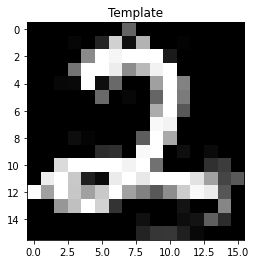

In [11]:
plt.figure()
plt.imshow(optim_template,cmap='gray')
plt.title("Template")
plt.show()

### Registered digits from estimated template

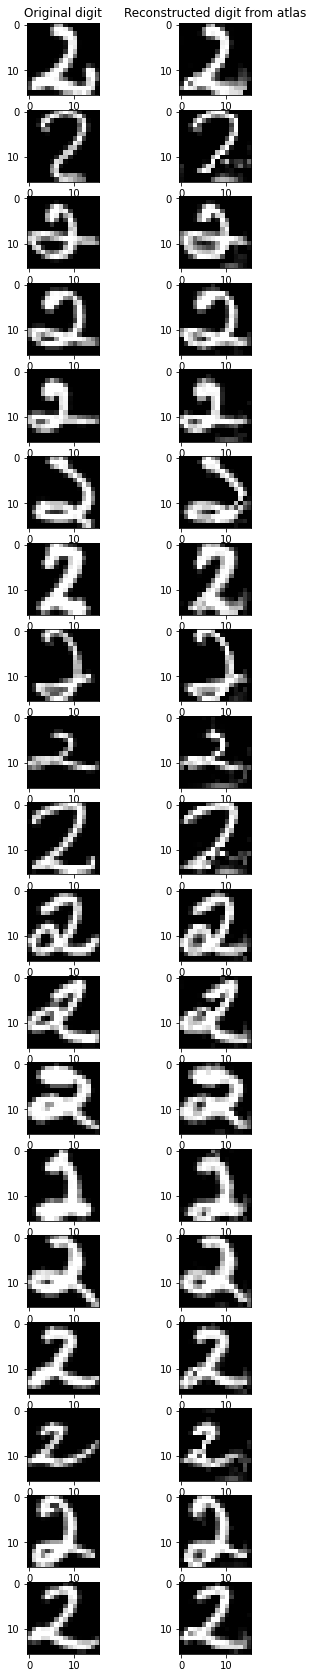

In [12]:
n_subjects = deformed_digits.shape[-1]
plt.figure(figsize=(5,30))
number_image = 1

for i in dico_images.keys():
    plt.subplot(n_subjects,2,number_image)
    plt.imshow(dico_images[i],cmap='gray')
    if i==1:
        plt.title('Original digit')

    plt.subplot(n_subjects,2,number_image+1)
    plt.imshow(deformed_digits[...,i-1],cmap='gray')
    if i==1:
        plt.title('Reconstructed digit from atlas')

    number_image += 2
plt.show()

# Segmentation 
Now that you have your estimated template, you want to segment it and segment data images.